In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline

In [35]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [36]:
#getting data and using it from yahoo
from pandas_datareader.data import DataReader
from pandas_datareader import data as pdr
# For time stamps
from datetime import datetime

### We will train the data on Apple stocks from yahoo

In [37]:
# Get the stock quote
df = pdr.get_data_yahoo('AAPL', start='2012-01-01', end=datetime.now())
# Lets see the data
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,14.621429,14.732143,14.607143,14.686786,12.500191,302220800
2012-01-04,14.642857,14.810000,14.617143,14.765714,12.567372,260022000
2012-01-05,14.819643,14.948214,14.738214,14.929643,12.706895,271269600
2012-01-06,14.991786,15.098214,14.972143,15.085714,12.839727,318292800
2012-01-09,15.196429,15.276786,15.048214,15.061786,12.819366,394024400
...,...,...,...,...,...,...
2023-02-06,152.570007,153.100006,150.779999,151.729996,151.498688,69858300
2023-02-07,150.639999,155.229996,150.639999,154.649994,154.414230,83322600
2023-02-08,153.880005,154.580002,151.169998,151.919998,151.688400,64120100


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2796 entries, 2012-01-03 to 2023-02-10
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2796 non-null   float64
 1   High       2796 non-null   float64
 2   Low        2796 non-null   float64
 3   Close      2796 non-null   float64
 4   Adj Close  2796 non-null   float64
 5   Volume     2796 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 152.9 KB


In [39]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2796.000000,2796.000000,2796.000000,2796.000000,2796.000000,2.796000e+03
mean,59.418384,60.092582,58.764332,59.454509,57.496498,2.022739e+08
std,48.398426,49.042261,47.782229,48.440384,48.969788,1.713962e+08
min,13.856071,14.271429,13.753571,13.947500,12.046193,3.519590e+07
25%,24.214375,24.429375,24.002500,24.219375,22.016306,9.435155e+07
50%,38.320002,38.507502,37.900000,38.289999,36.195610,1.381464e+08
75%,79.463123,80.140003,78.926249,79.603750,78.086439,2.450959e+08
max,182.630005,182.940002,179.119995,182.009995,180.683853,1.506120e+09


In [40]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [44]:
features = df.columns

In [45]:
features

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

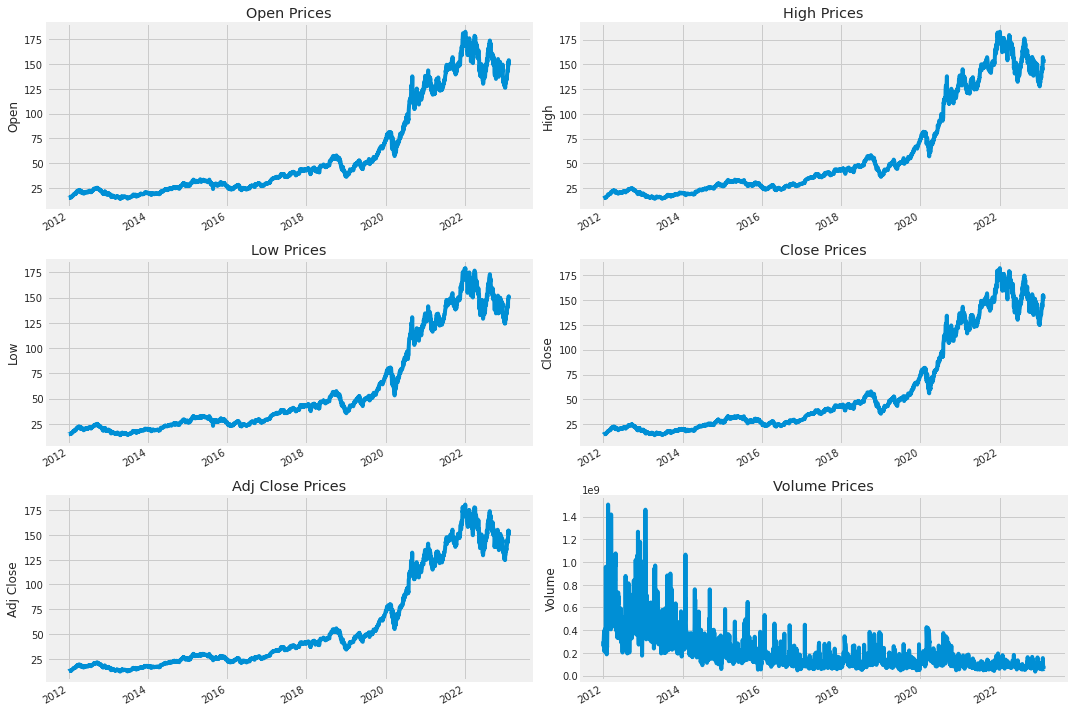

In [71]:
# a view of the all the features of stock
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i in range(len(features)):
    feature = features[i]
    plt.subplot(3, 2, i+1)
    df[feature].plot()
    plt.ylabel(feature)
    plt.xlabel(None)
    plt.title(f'{feature} Prices')
    
plt.tight_layout()

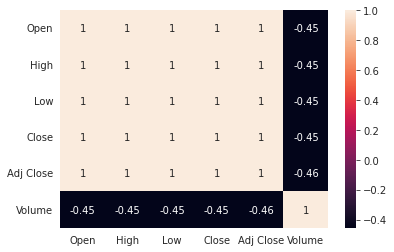

In [53]:
sns.heatmap(df.corr(), linecolor='black', cbar=True, annot=True)

### Clearly the data from different features such as Open, High, Low and Close are very similar. We can see a correspondence of 1 as seen above.
### As a result we don't need to train our model on all of them to get a good prediction.
### We will train our model only on the close feature.

# Preparing data for training

In [54]:
# Create a new dataframe with only the 'Close column 
data = df.filter(['Close'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))

In [56]:
training_data_len

2657

### Transforming data using minmax scale to get all the values between 0 and 1. This will be important later when we use different company stocks as they may differ in prices drastically.

In [59]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [60]:
scaled_data

array([[0.00439887],
       [0.00486851],
       [0.00584391],
       ...,
       [0.82095948],
       [0.81471179],
       [0.81554481]])

### We will create blocks of 60 which will act as features and the 61th element will be its label

In [63]:
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    print(f"When the features are {x_train[i-60][:3]}...{x_train[i-60][-2:]} the label will be {y_train[i-60]} \n")

Streaming output truncated to the last 5000 lines.
When the features are [0.0353695  0.03825746 0.03714392]...[0.05124794 0.05106518] the label will be 0.052236097021115424 

When the features are [0.03825746 0.03714392 0.03650002]...[0.05106518 0.0522361 ] the label will be 0.054737290117732595 

When the features are [0.03714392 0.03650002 0.03862083]...[0.0522361  0.05473729] the label will be 0.05835839552164909 

When the features are [0.03650002 0.03862083 0.04008713]...[0.05473729 0.0583584 ] the label will be 0.056426708799160036 

When the features are [0.03862083 0.04008713 0.03978112]...[0.0583584  0.05642671] the label will be 0.05914891317753268 

When the features are [0.04008713 0.03978112 0.03622376]...[0.05642671 0.05914891] the label will be 0.05782287953413173 

When the features are [0.03978112 0.03622376 0.03692503]...[0.05914891 0.05782288] the label will be 0.057948252422575425 

When the features are [0.03622376 0.03692503 0.03661477]...[0.05782288 0.05794825] t

In [64]:
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [65]:
x_train.shape

(2597, 60, 1)

### Now we build a model using LSTM

In [75]:
# importing modules
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

2597/2597 [==============================] - 114s 42ms/step - loss: 0.0015


Creating the testing dataset

In [76]:
# Create a new array containing scaled values from index 1543 to 2002 
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [77]:
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

5/5 [==============================] - 1s 40ms/step


4.804208313146216

<ipython-input-79-0cdd5e68a3a9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


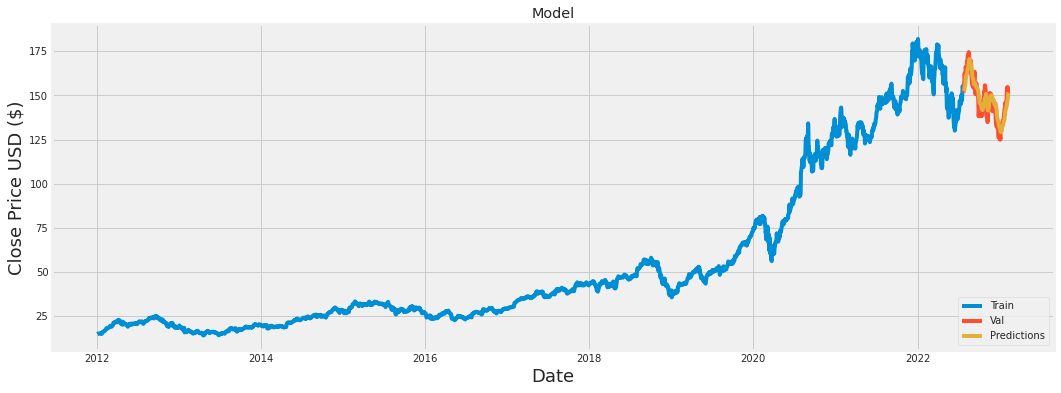

In [79]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [82]:
valid.head()

,Close,Predictions
Date,,
2022-07-26,151.600006,152.388962
2022-07-27,156.789993,152.577881
2022-07-28,157.350006,153.238373
2022-07-29,162.509995,154.069977
2022-08-01,161.509995,155.572296


In [83]:
model.save('/content/drive/MyDrive/Stocks/LSTM_model')

## Now we will try the model on a different stock 

In [84]:
#getting some other company data
new_df = pdr.get_data_yahoo('GOOG', start='2012-01-01', end=datetime.now())
new_df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,16.262545,16.641375,16.248346,16.573130,16.573130,147611217
2012-01-04,16.563665,16.693678,16.453827,16.644611,16.644611,114989399
2012-01-05,16.491436,16.537264,16.344486,16.413727,16.413727,131808205
2012-01-06,16.417213,16.438385,16.184088,16.189817,16.189817,108119746
2012-01-09,16.102144,16.114599,15.472754,15.503389,15.503389,233776981


We will just repeat what we did above

In [115]:
gdata = new_df.filter(['Close'])
gdf = gdata.values

In [119]:
test_data_len = int(np.ceil( len(gdf) * .80 ))

In [120]:
test_data_len

2237

In [121]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_gdf = scaler.fit_transform(gdf)
scaled_gdf

array([[0.01936668],
       [0.01988927],
       [0.01820133],
       ...,
       [0.62927937],
       [0.59608857],
       [0.59170214]])

In [122]:
test_data = scaled_gdf[test_data_len - 60: , :]
x_test = []
y_test = gdf[test_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

preds = model.predict(x_test)
preds = scaler.inverse_transform(preds)
preds[:10]

18/18 [==============================] - 1s 44ms/step


array([[90.02839 ],
       [89.881676],
       [89.64077 ],
       [89.62394 ],
       [89.73358 ],
       [90.04075 ],
       [90.17553 ],
       [90.46779 ],
       [90.99315 ],
       [91.546196]], dtype=float32)

In [123]:
rmse = np.sqrt(np.mean( ( (preds - y_test) ** 2 )))
rmse

3.627784693583365

<ipython-input-125-dc59dd078398>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = preds


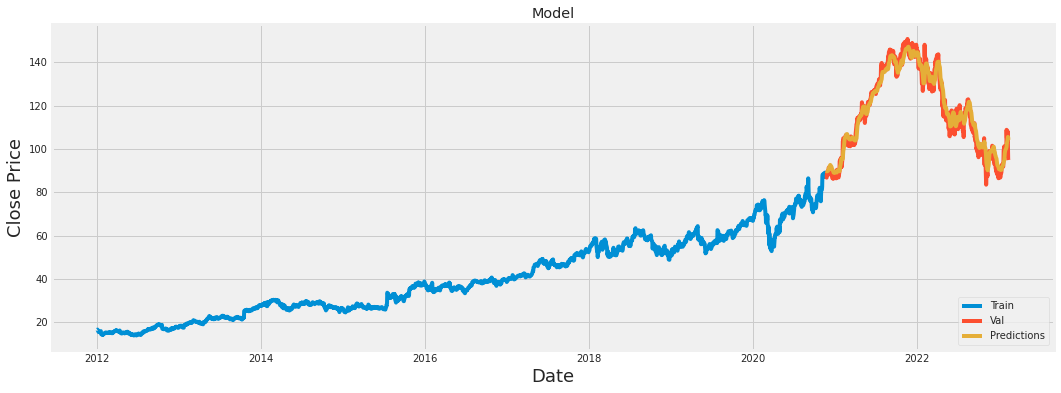

In [125]:
# Plot the data
train = gdata[:test_data_len]
valid = gdata[test_data_len:]
valid['Predictions'] = preds

plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()